In [1]:
# vector store dependency
from langchain_chroma import Chroma
from langchain_community.embeddings import Model2vecEmbeddings

# chat model
from langchain.chat_models import init_chat_model


from typing import TypedDict, List
from langgraph.graph import StateGraph, START, END
import rich

import uuid
from typing import TypedDict, Annotated
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from collections import deque


/home/bee/miniforge3/envs/qwenrag/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
#===============================
#           Config
#===============================

MODEL_NAME = "qwen2.5:7b-instruct"
VEC_EMBED_NAME = "minishlab/potion-base-8M"
PERSIST_DIR=  "./data/chromadb"
DOC_NUM = 3 # number of documents to retrieve
MAX_MEMORY_SIZE = 8 # max number of messages to keep in history

In [3]:
#===============================
#       Load Vector Store
#===============================

embeddings = Model2vecEmbeddings(VEC_EMBED_NAME)


vector_store = Chroma(
    persist_directory=PERSIST_DIR,
    embedding_function=embeddings,
    collection_name="model2vec_embeddings_3"
)

print(f"Loaded {vector_store._collection.count()} vectors.")

Loaded 157817 vectors.


In [4]:


# import model through ollama
model = init_chat_model(
    model=MODEL_NAME,
    model_provider="ollama",
    temperature=0,
)

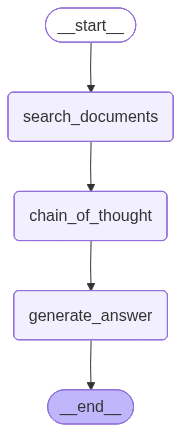

In [ ]:
response_model = model




class Message(TypedDict):
    role: str  
    content: str

class RAGState(TypedDict):
    question: str
    history: list[Message]
    retrieved_docs: list[str]
    count_retrieval: int = 0
    answer: str = ""
    thought: str = ""
    rewritten_queries: list[str] | None = None
    count_regenerate: int = 0
    should_do_search: bool = True


def search_documents(state: RAGState):
    """Search documents."""
    question = state["question"]
    retrieved_docs = vector_store.similarity_search(question, k=DOC_NUM)
    context = [doc.page_content for doc in retrieved_docs]
    all_retrieved_docs = state.get("retrieved_docs", []) + context
    all_retrieved_docs = list(set(all_retrieved_docs))
    return {"retrieved_docs": all_retrieved_docs}

def chain_of_thought(state: RAGState):
    """Think step by step"""


    GENERATE_PROMPT = (
        "You are an assistant for question-answering tasks. "
        "Use the following pieces of retrieved context and conversation history to answer the question. "
        "If you don't know the answer, just say that you don't know. "
        """ Think step by step using the following structure:
        1. **Understand**: Restate the problem in your own words and identify key elements.
        2. **Gather**: List all relevant facts, assumptions, or data from the context.
        3. **Break Down**: Divide the problem into smaller, manageable sub-problems or steps.
        4. **Solve/Analyze**: Address each sub-step logically. Show calculations, reasoning justifications, or trade-offs.
        5. **Verify**: Check for errors, inconsistencies, or alternative perspectives.
        6. **Conclude**: Summarize the final answer or recommendation clearly.\n\n"""
        "Question: {question} \n"
        "History: {history}\n"
        "Context: {context}"
    )

    question = state["question"]
    context = "\n\n".join(state["retrieved_docs"])
    history = state.get("history",[])
    history = "\n".join([f"{msg['role']}: {msg['content']}" for msg in history]) if history else "None"
    prompt = GENERATE_PROMPT.format(question=question, context=context, history=history)
    response = response_model.invoke([{"role": "user", "content": prompt}])
    return {"thought": response.content}


def generate_answer(state: RAGState):
    """Generate an answer."""

    GENERATE_PROMPT = (
        "You are an assistant for question-answering tasks. "
        "Based on the conclusion of chain of thoughts to answer the question. "
        "Beginning with 'Answer:' to answer the question"
        "Keep the answer concise and simple.\n"

        "Question: {question} \n"
        "Chain of Thought: {thought}\n"
    )


    question = state["question"]
    thought = state["thought"]

    prompt = GENERATE_PROMPT.format(question=question,thought=thought)
    response = response_model.invoke([{"role": "user", "content": prompt}])
    response = response.content.split("Answer:")[-1].strip()


    # update history
    history = state.get("history", [])
    history.append(Message(role="user", content=question))
    history.append(Message(role="assistant", content=response))

    # remove old history
    if len(history) > MAX_MEMORY_SIZE:
        history = history[MAX_MEMORY_SIZE:]

    # reply the question, 
    # save the conversation history 
    # and clean the retrived docs for question in next round
    return {"answer": response, "history": history, "retrieved_docs": []}


workflow = StateGraph(RAGState)
workflow.add_node(search_documents)
workflow.add_node(generate_answer)
workflow.add_node(chain_of_thought)
workflow.add_edge(START, "search_documents")
workflow.add_edge("search_documents", "chain_of_thought")
workflow.add_edge("chain_of_thought", "generate_answer")
workflow.add_edge("generate_answer", END)

# memory checkpointer for mult-turn conversation
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)

import IPython
IPython.display.Image(graph.get_graph().draw_mermaid_png())

In [27]:

# fix thread id for mult-turn conversation
config = {"configurable": {"thread_id": str(uuid.uuid4())}}
questions = [
    "What island is included in the geographic area home to a variety of publications describing Hong Kong Cantonese as \"Hong Kong speech\"?",
    "where is the island",
    "what country does it belong to?",
]
for q in questions:
    for chunk in graph.stream({"question": q}, config):
        for node, update in chunk.items():
            print("-" * 10 + f" {node} " + "-" * 10)
            if node == "search_documents":
                print(f"Retrieved {len(update['retrieved_docs'])} docs")
            else:
                print(update)
            print("\n")

---------- search_documents ----------
Retrieved 2 docs


---------- chain_of_thought ----------
{'thought': 'Let\'s approach this step-by-step:\n\n1. **Understand**: The question asks about an island included in the geographic area where various publications refer to Hong Kong Cantonese as "Hong Kong speech."\n\n2. **Gather**:\n   - New Territories is one of the three main regions of Hong Kong.\n   - It includes a mainland area and over 200 outlying islands.\n   - The outlying islands include Lantau Island, Lamma Island, Cheung Chau, and Peng Chau.\n\n3. **Break Down**:\n   - We need to identify which of these islands are part of the geographic area where "Hong Kong speech" is described in publications.\n   - Since New Territories encompasses a large portion of Hong Kong\'s territory, it’s reasonable to assume that all outlying islands mentioned could be included unless specified otherwise.\n\n4. **Solve/Analyze**:\n   - The context mentions that various publications describe Hong Kon